<a href="https://colab.research.google.com/github/kimdain0222/deep_learning2/blob/main/11%EC%A3%BC%EC%B0%A8(%EA%B5%90%EC%88%98ver)BGD_mBGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## 1. Data Load, X/y 분리, train/test 분리

In [5]:
dataset = pd.read_csv('11주차데이터_banknote.csv',header=None).values
# header=None: 첫번째 행을 데이터 행으로 간주 (default: 첫번째 행이 열의 이름이 됨)

- **banknote.csv**
> - 위조지폐/정상지폐 분류를 위한 데이터
> - **index 0 - index 3 column**: 특징 `X`(지폐 이미지로부터 추출한 4개의 특징)
> - **index 4 (-1)**: 라벨 `t`(위조지폐/정상지폐)

In [6]:
X = dataset[:,:-1]
# 추후 t를 OneHotEncoder에 적용할 수 있도록, 2d array로 추출함
t = dataset[:,-1:]

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,t_train_tmp,t_test_tmp = train_test_split(X,t,test_size=0.3,random_state=42)

In [8]:
# t One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(t_train_tmp)
t_train = ohe.transform(t_train_tmp).toarray()
t_test = ohe.transform(t_test_tmp).toarray()

## 2. activation function / cost function 정의

In [9]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [10]:
def d_sigmoid(a):
    return sigmoid(a) * (1 - sigmoid(a))

In [11]:
# ReLu 정의
def relu(a):
    return np.where(a>0,a,0)

In [12]:
# Relu의 미분 정의
def d_relu(a):
    return np.where(a>0,1,0)

In [13]:
# cost function: MSE
def mse(t,y):
    return 0.5 * np.mean((y-t)**2)

## 3. MLP structure
- **input layer node의 수**: 특징의 수, `X.shape[1]`
- **hidden layer node의 수**: `16`
- **output layer node의 수**: class의 수, `t.shape[1]` (OneHotEncoding된 t에 대해)
- `W1.shape`: (**input layer node의 수, hidden layer node의 수**)
- `W2.shape`: (**hidden layer node의 수, output layer node의 수**)
- `b1.shape`: (**hidden layer node의 수**,)
- `b2.shape`: (**output layer node의 수**,)
- `W2_b.shape`(backpropagation): (**output layer node의 수, hidden layer node의 수**)
- `W1_b.shape`(backpropagation): (**hidden layer node의 수, input layer node의 수**)

In [14]:
# 학습데이터의 수
num_data = X_train.shape[0]
# input layer node
input_node = X_train.shape[1]
# hidden layer node
hidden_node = 16
# output layer node
output_node = t_train.shape[1]

In [15]:
# W와 b 초기화
np.random.seed(42)
W1_init = np.random.randn(input_node,hidden_node)
W2_init = np.random.randn(hidden_node,output_node)
b1_init = np.random.randn(hidden_node)
b2_init = np.random.randn(output_node)
W1_b_init = W1_init.T
W2_b_init = W2_init.T

## 4. MLP predict 정의

In [16]:
def predict(X,W1,W2,b1,b2):
    a1 = X.dot(W1) + b1
    z1 = relu(a1)   # hidden layer의 activation function: ReLu
    a2 = z1.dot(W2) + b2
    y = sigmoid(a2) # output layer의 activation function: sigmoid
    return a1,z1,a2,y

## 5-(1). Batch Gradient Descent

In [17]:
bgd_epochs = 1000
bgd_update = 0
eta = 0.1
W1 = W1_init
W2 = W2_init
b1 = b1_init
b2 = b2_init
W1_b = W1_b_init
W2_b = W2_b_init
bgd_cost = []

In [18]:
for i in range(bgd_epochs):
    a1,z1,a2,y = predict(X_train,W1,W2,b1,b2)
    bgd_cost.append(mse(t_train,y))

    del_out = (y-t_train) * d_sigmoid(a2)
    del_hid = del_out.dot(W2_b) * d_sigmoid(a1)

    W2_b = W2_b - (eta/num_data)*del_out.T.dot(z1)
    W1_b = W1_b - (eta/num_data)*del_hid.T.dot(X_train)

    b2 = b2 - (eta/num_data)*np.sum(del_out,axis=0)
    b1 = b1 - (eta/num_data)*np.sum(del_hid,axis=0)

    W1 = W1_b.T
    W2 = W2_b.T
    # bgd의 가중치/편향 업데이트 횟수 기록
    bgd_update += 1

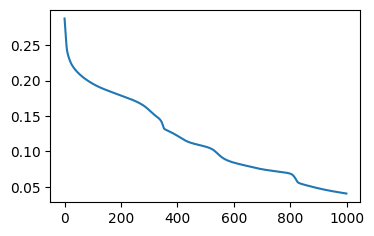

In [19]:
plt.figure(figsize=(4,2.5))
plt.plot(bgd_cost)

In [20]:
# 학습 완료 후, 가중치/편향 저장
W1_bgd, W2_bgd, b1_bgd, b2_bgd = W1, W2, b1, b2

In [21]:
# 학습 완료된 가중치와 편향 기반의 예측값에 대한 cost(MSE)
_,_,_,bgd_y = predict(X_train,W1_bgd,W2_bgd,b1_bgd,b2_bgd)
final_bgd_cost = mse(t_train,bgd_y)

## 5-(2). mini Batch Graident Descent

In [22]:
mbgd_epochs = 100
mbgd_update = 0
eta = 0.1
# 하나의 batch에 속한 데이터의 수
batch_size = 64
# 학습데이터가 포함하는 batch의 수 (ceil의 결과는 float이므로 int로 변환)
batch_num = int(np.ceil(num_data/batch_size))
W1 = W1_init
W2 = W2_init
b1 = b1_init
b2 = b2_init
W1_b = W1_b_init
W2_b = W2_b_init
mbgd_cost = []

In [23]:
# X_train과 t_train을 shuffle함
X_rand,t_rand = shuffle(X_train,t_train)

for i in range(mbgd_epochs):
    # 각 epoch에 대한 cost(MSE) 저장 - optional, 아래 2 line은 GD에 필요한 코드가 아님
    _,_,_,y_i = predict(X_train,W1,W2,b1,b2)
    mbgd_cost.append(mse(t_train,y_i))

    # 각 batch에 대해 BGD를 수행함
    # j는 batch의 index를 의미함
    for j in range(batch_num):
        X_batch = X_rand[j*batch_size:(j+1)*batch_size]
        t_batch = t_rand[j*batch_size:(j+1)*batch_size]
        # 마지막 batch의 경우, batch가 포함한 데이터의 수가
        # batch_size와 일치하지 않을 수 있으므로, X_batch.shape으로 batch크기를 다시 측정
        current_batch_size = X_batch.shape[0]

        a1,z1,a2,y = predict(X_batch,W1,W2,b1,b2)

        del_out = (y-t_batch) * d_sigmoid(a2)
        del_hid = del_out.dot(W2_b) * d_sigmoid(a1)

        W2_b = W2_b - (eta/current_batch_size)*del_out.T.dot(z1)
        W1_b = W1_b - (eta/current_batch_size)*del_hid.T.dot(X_batch)

        b2 = b2 - (eta/current_batch_size)*np.sum(del_out,axis=0)
        b1 = b1 - (eta/current_batch_size)*np.sum(del_hid,axis=0)

        W1 = W1_b.T
        W2 = W2_b.T
        # mini bgd 가중치/편향 업데이트 횟수 기록
        mbgd_update += 1

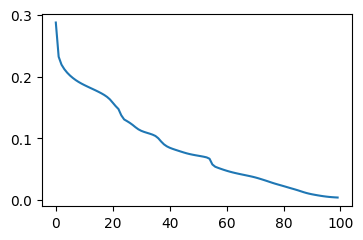

In [24]:
plt.figure(figsize=(4,2.5))
plt.plot(mbgd_cost)

In [25]:
# 학습 완료 후, 가중치/편향 저장
W1_mbgd, W2_mbgd, b1_mbgd, b2_mbgd = W1, W2, b1, b2

In [26]:
# 학습 완료된 가중치와 편향 기반의 예측값에 대한 cost(MSE)
_,_,_,mbgd_y = predict(X_train,W1_mbgd,W2_mbgd,b1_mbgd,b2_mbgd)
final_mbgd_cost = mse(t_train,mbgd_y)

In [27]:
print('[Batch Gradient Descent]')
print(' - epochs : ', bgd_epochs)
print(' - updates: ', bgd_update)
print(' - cost   :', final_bgd_cost)
print('[mini Batch Gradient Descent]')
print(' - epochs : ', mbgd_epochs)
print(' - updates: ', mbgd_update)
print(' - cost   :', final_mbgd_cost)

[Batch Gradient Descent]
 - epochs :  1000
 - updates:  1000
 - cost   : 0.04053301154809686
[mini Batch Gradient Descent]
 - epochs :  100
 - updates:  1500
 - cost   : 0.003961152404055696


## 6. test data를 통한 성능 평가

In [28]:
# BGD의 X_test에 대한 예측값
_,_,_,bgd_pred_tmp = predict(X_test,W1_bgd,W2_bgd,b1_bgd,b2_bgd)
# mini BGD의 X_test에 대한 예측값
_,_,_,mbgd_pred_tmp = predict(X_test,W1_mbgd,W2_mbgd,b1_mbgd,b2_mbgd)

- `bgd_pred_tmp`와 `mbgd_pred_tmp`의 첫번째 열의 값은 output layer 첫번째 node의 값, 두번째 열의 값은 output layer 두번째 node의 값을 의미함
- 최종적으로 첫번째 열과 두번째 열 값 중 더 큰 값에 속하는 node의 index를 추출하는 과정이 필요함
- `np.argmax(ndarray,axis)`: `ndarray`에서 `axis`를 기준으로 가장 큰 값에 대한 index를 반환
> - `axis=0`: 각 열에 대해, **가장 큰 값을 갖는 행의 index** 반환
> - `axis=1`: 각 행에 대해, **가장 큰 값을 갖는 열의 index** 반환

In [29]:
# 각 행에 대해서 큰 값을 갖는 열의 index를 반환 (두개의 class이므로, 0 또는 1)
bgd_pred = np.argmax(bgd_pred_tmp,axis=1)
mbgd_pred = np.argmax(mbgd_pred_tmp,axis=1)

In [30]:
# t_test도 위와 동일한 방식으로 1d array로 변환함
target = np.argmax(t_test,axis=1)

In [31]:
# sklearn의 metric을 통해 성능 평가
from sklearn.metrics import confusion_matrix, accuracy_score
print('[Batch GD]')
print('Confusion matrix: \n', confusion_matrix(target,bgd_pred))
print('Accuracy: ',accuracy_score(target,bgd_pred))
print('------------------------------')
print('[mini-Batch GD]')
print('Confusion matrix: \n', confusion_matrix(target,mbgd_pred))
print('Accuracy: ',accuracy_score(target,mbgd_pred))

[Batch GD]
Confusion matrix: 
 [[142  41]
 [  0 229]]
Accuracy:  0.9004854368932039
------------------------------
[mini-Batch GD]
Confusion matrix: 
 [[181   2]
 [  0 229]]
Accuracy:  0.9951456310679612
